In [1]:
import numpy as np
import pickle
from glob import glob
import corner
from mcmc import Ebola

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 22})

In [3]:
par = ('beta', 'k', 'tau', 'sigma', 'gamma', 'f', 'offset',
       'scatter_cases', 'prob_cases_outlier',
       'scatter_deaths', 'prob_deaths_outlier')
ndim = len(par)  # number of parameters in the model
nburn = 400
N = 1000000

In [51]:
#country = 'guinea'; lnprob_limit = -930
#country = 'liberia'; lnprob_limit = -10000
country = 'sierraleone'; lnprob_limit = -10000

In [52]:
binning = 'weekly'
#binning = 'daily'

In [53]:
e = Ebola(N, country, weekly=binning=='weekly')

In [54]:
filename = sorted(glob('{}/chain-{}*'.format(binning, country)))[-1]
print(filename)

weekly/chain-sierraleone-2019-05-29T23:39


In [55]:
with open(filename, 'rb') as f:
    chain, lnprob = pickle.load(f)
print(chain.shape)
print(lnprob.shape)

(500, 801, 11)
(500, 801)


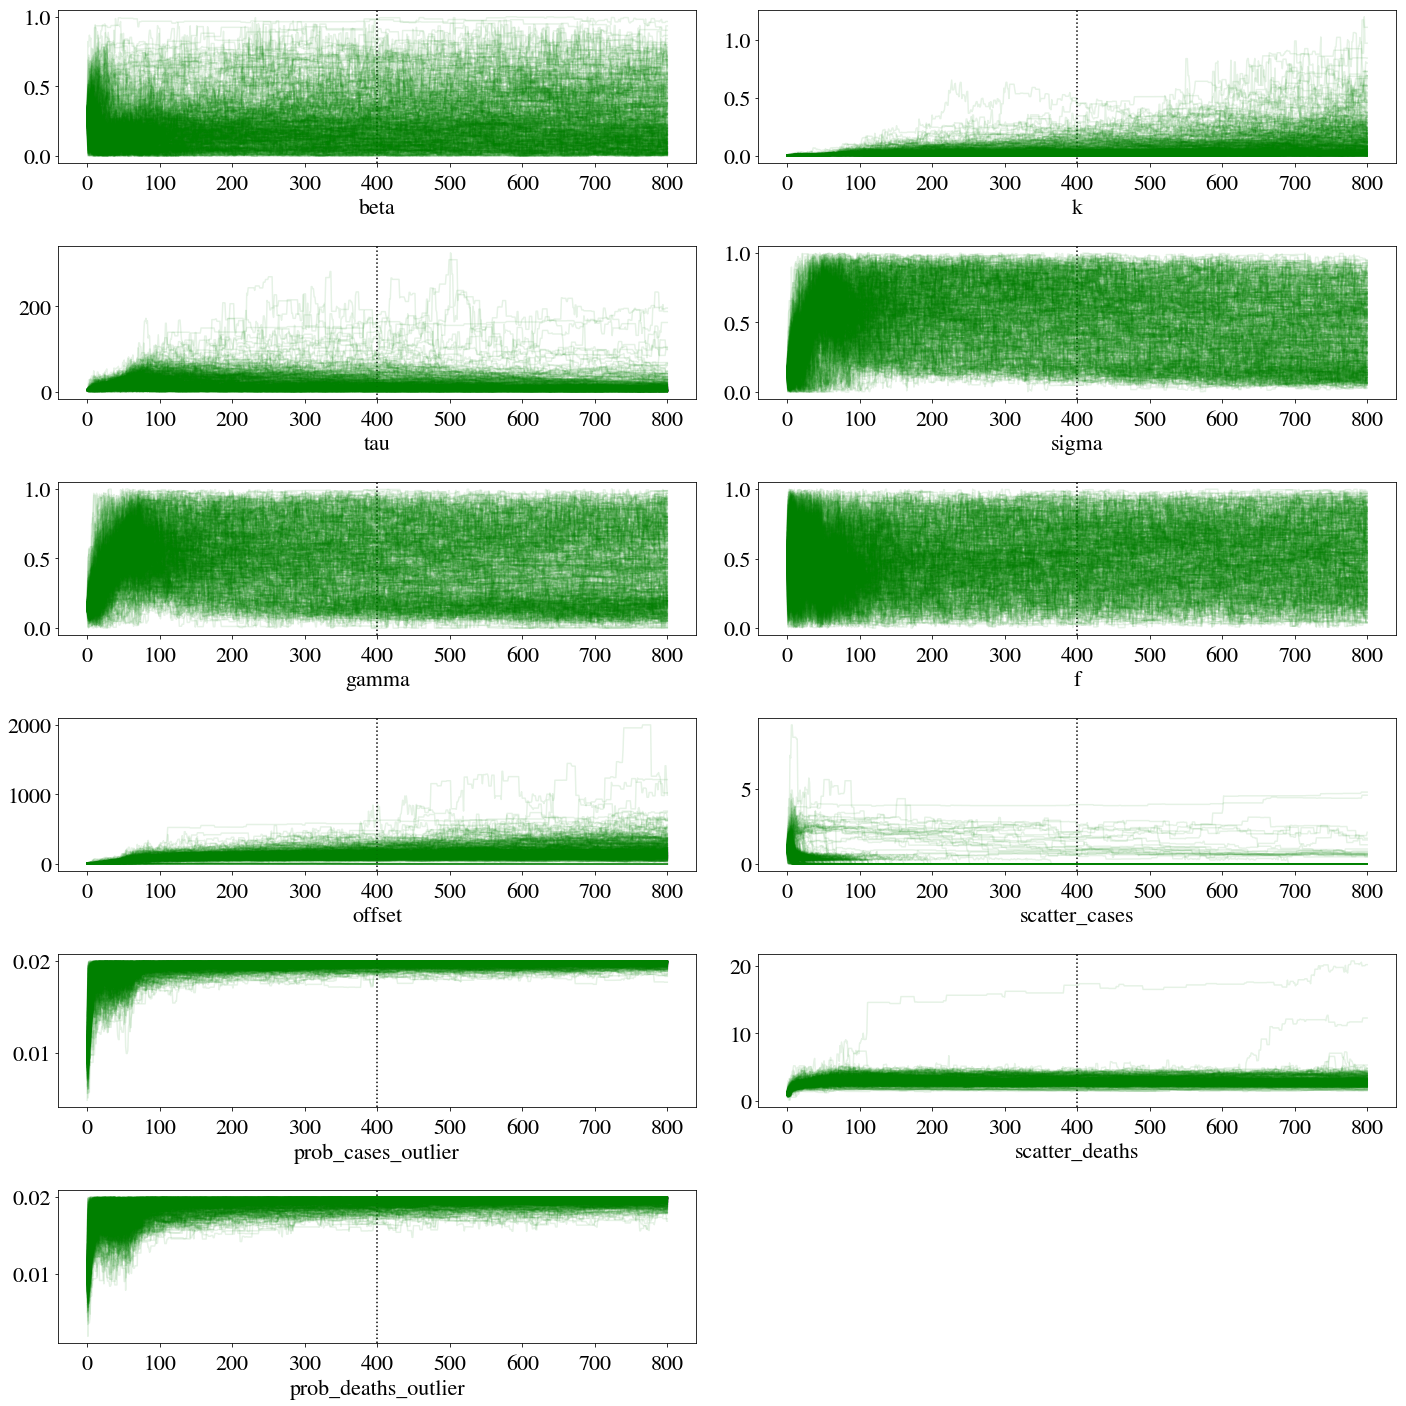

In [56]:
# plot the chains to visually assess convergence
plt.figure(figsize=[20,20])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    for w in range(chain.shape[0]):
            #plt.plot(numpy.arange(chain.shape[2]), chain[2,w,:,i], 'r-', alpha=0.1)
            plt.plot(numpy.arange(chain.shape[1]), chain[w,:,i], 'g-', alpha=0.1)
    plt.xlabel(p)
    aymin, aymax = plt.ylim()
    plt.vlines(nburn, aymin, aymax, linestyle=':')
    plt.ylim(aymin, aymax)
    plt.tight_layout()
plt.savefig('plots/emcee_all_chains_{}.pdf'.format(country))

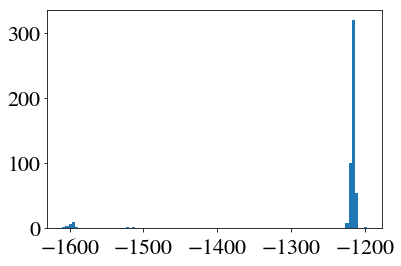

In [57]:
plt.hist(lnprob[:, -100:].mean(axis=1), bins=100);
plt.savefig('plots/emcee_all_lnprob_{}.pdf'.format(country))

In [61]:
lnprob_limit = -1350
chain = chain[lnprob[:, -200:].mean(axis=1) > lnprob_limit]
lnprob = lnprob[lnprob[:, -200:].mean(axis=1) > lnprob_limit]

chain = chain[lnprob[:, -200:].mean(axis=1) < -1211]
lnprob = lnprob[lnprob[:, -200:].mean(axis=1) < -1211]

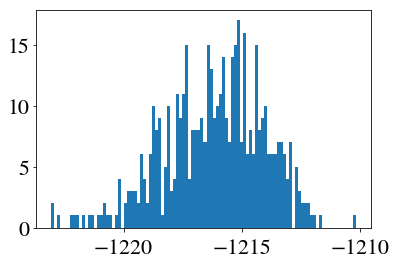

In [62]:
plt.hist(lnprob[:, -100:].mean(axis=1), bins=100);
plt.savefig('plots/emcee_good_lnprob_{}.pdf'.format(country))

In [63]:
print(lnprob.shape[0])

477


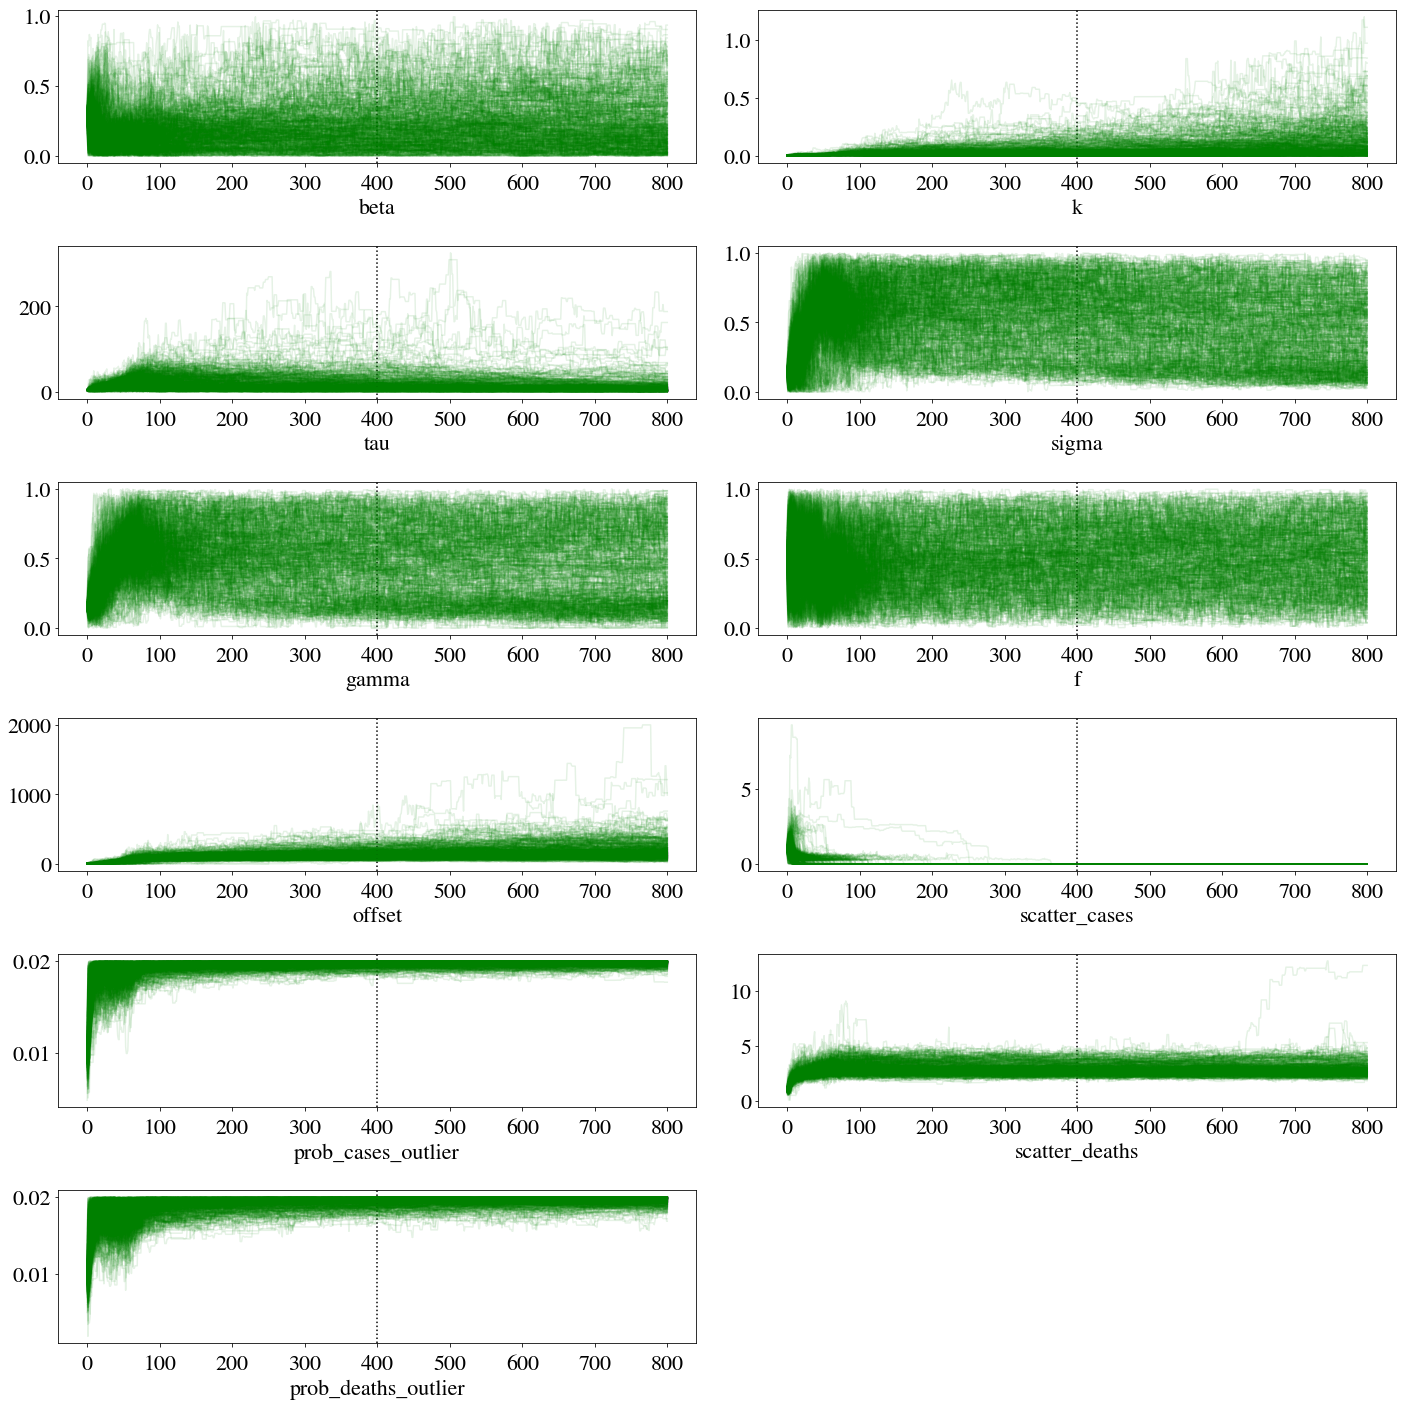

In [64]:
# plot the chains to visually assess convergence
plt.figure(figsize=[20,20])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    for w in range(chain.shape[0]):
            #plt.plot(numpy.arange(chain.shape[2]), chain[2,w,:,i], 'r-', alpha=0.1)
            plt.plot(numpy.arange(chain.shape[1]), chain[w,:,i], 'g-', alpha=0.1)
    plt.xlabel(p)
    aymin, aymax = plt.ylim()
    plt.vlines(nburn, aymin, aymax, linestyle=':')
    plt.ylim(aymin, aymax)
    plt.tight_layout()
plt.savefig('plots/emcee_good_chains_{}.pdf'.format(country))

In [65]:
# plot the chains to visually assess auto correlation time at equilibrium
#plt.figure(figsize=[20,20])
#for i, p in enumerate(par):
#    plt.subplot((ndim+1)//2, 2, i+1)
#    for w in range(0,nwalkers,10):
#            plt.plot(numpy.arange(100), chain[2,w,nburn:nburn+100,i], 'r-')
#            plt.plot(numpy.arange(100), chain[0,w,nburn:nburn+100,i], 'g-')
#    plt.xlabel(p)
#    aymin = np.min(chain[0,:,nburn:,i])
#    aymax = np.max(chain[0,:,nburn:nburn+100,i])
#    plt.ylim(aymin, aymax)
#    plt.tight_layout()

In [66]:
def get_samples(c, nburn):
    if c.ndim == 4:
        c = c[0]
    c = c[:, nburn:]
    return c.reshape((np.product(c.shape[:-1]), c.shape[-1]))

In [67]:
samples = get_samples(chain, nburn)
samples_lnprob = lnprob[:, nburn:].flatten()

In [68]:
#samples = samples[samples_lnprob > -390]

In [69]:
def round_sig(x, sig=1):
    d = sig-int(floor(log10(x)))-1
    d = max(0, d)
    return round(x, d), d


def summary(samples, truths=None, filename=None):
    mean = samples.mean(0)
    sigma = samples.std(0)
    if filename is not None:
        f = open(filename, 'a')
    else:
        f = None
    for i, p in enumerate(par):
        err, dp = round_sig(sigma[i], 1)
        val = round(mean[i], dp)
        dp = str(dp)
        try:
            dp += 'e}' if abs(log10(val)) > 3 else 'f}'
        except ValueError:
            dp += 'f}'
        outstr = ('{:22s} = {:6.'+dp+' ± {:<8.'+dp).format(p, val, err)
        if truths is not None:
            outstr += ('   ('+dp+')').format(truths[i])
        print(outstr, file=f)
    if filename is not None:
        f.close()

In [70]:
summary(samples)
summary(samples, filename='emcee_summary_{}'.format(country))

beta                   =    0.2 ± 0.2     
k                      =    0.1 ± 0.1     
tau                    =     14 ± 20      
sigma                  =    0.5 ± 0.3     
gamma                  =    0.4 ± 0.3     
f                      =    0.5 ± 0.2     
offset                 =    179 ± 115     
scatter_cases          = 9.0000000000e-10 ± 1.0000000000e-10
prob_cases_outlier     = 0.0197 ± 0.0003  
scatter_deaths         =    2.9 ± 0.6     
prob_deaths_outlier    = 0.0194 ± 0.0006  


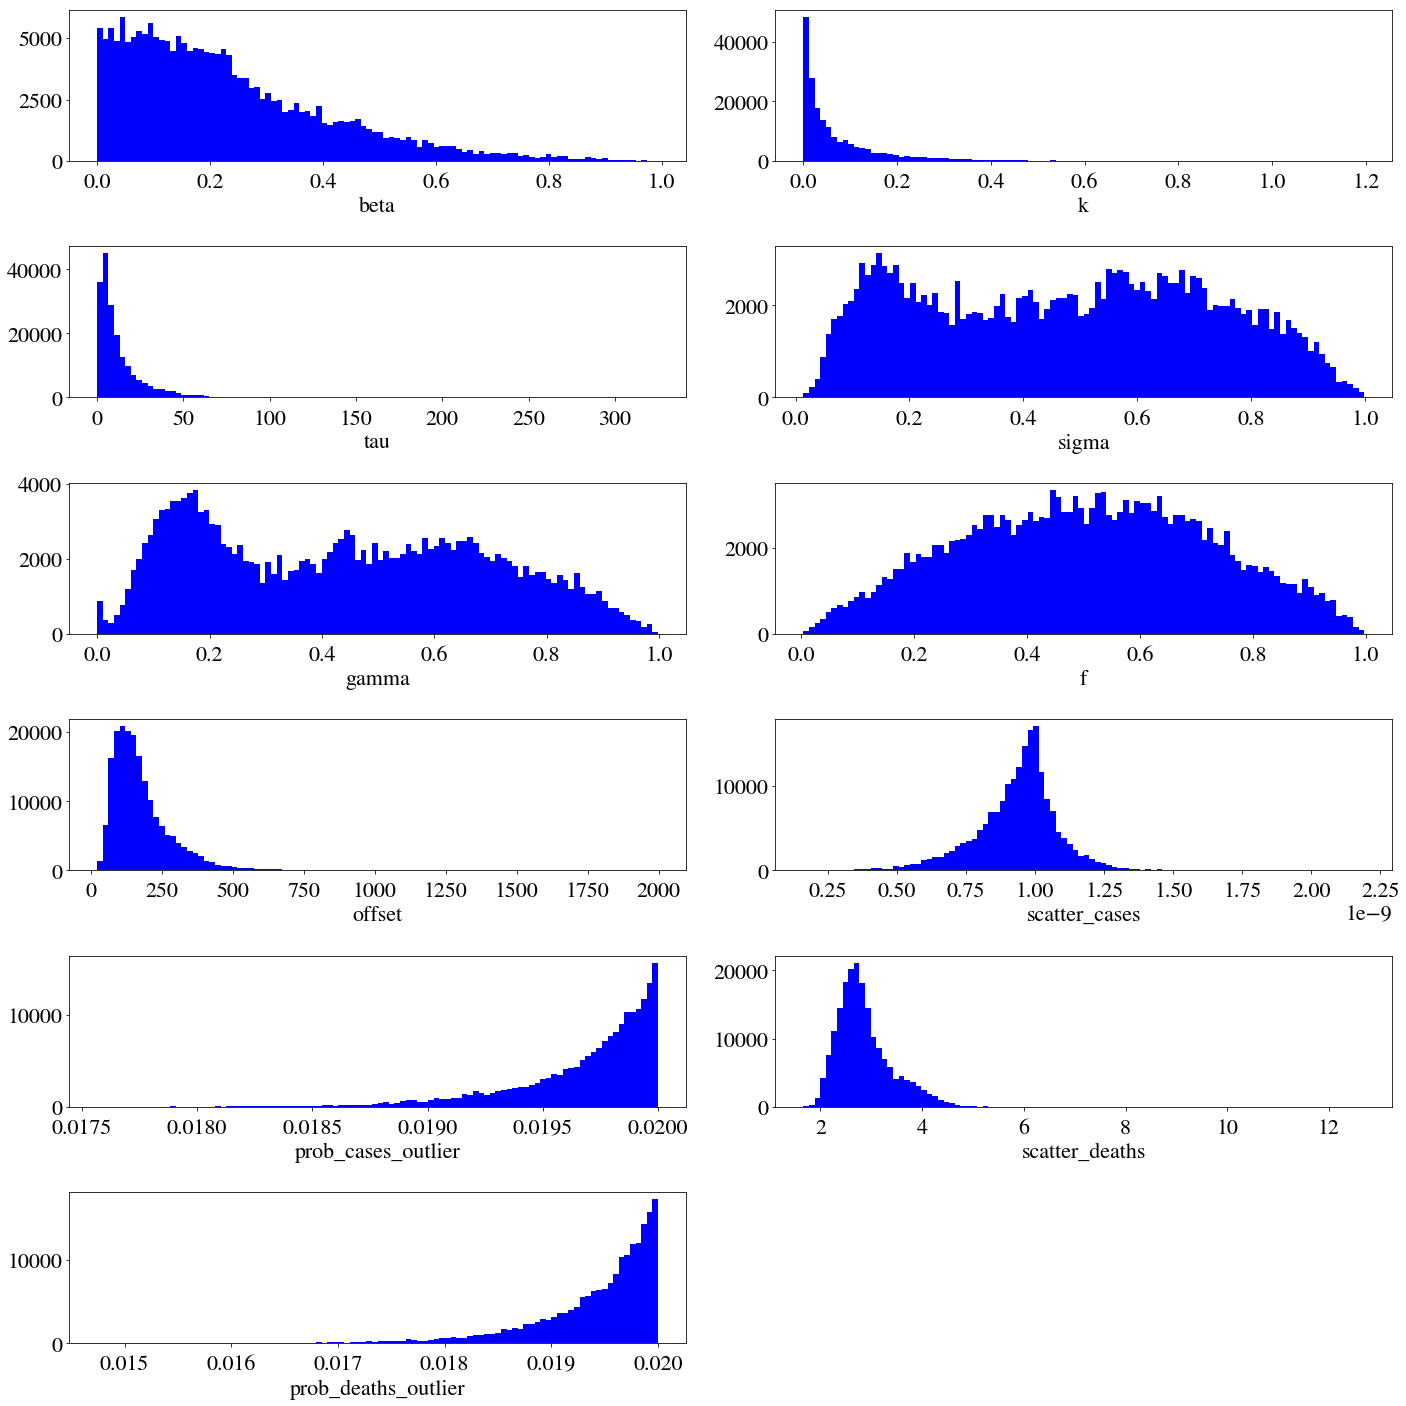

In [71]:
# examine parameter histograms
plt.figure(figsize=[20,20])
for i, p in enumerate(par):
    plt.subplot((ndim+1)//2, 2, i+1)
    n, b, patches = plt.hist(samples[:,i], bins=100, color='b', histtype='stepfilled', log=False)
    plt.xlabel(p)
    plt.tight_layout()
plt.savefig('plots/emcee_param_hist_{}.pdf'.format(country))

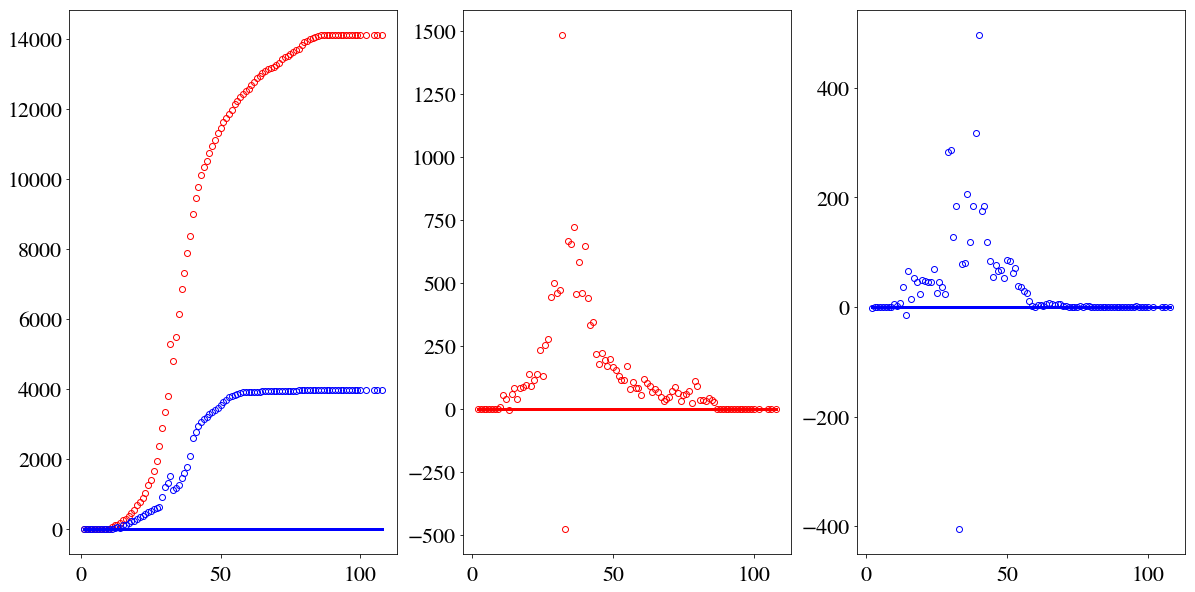

In [72]:
selection = np.random.choice(len(samples), 1000, replace=True)
e.makeplot(samples=samples[selection])
#plt.gcf().axes[0].set_ylim(top=10000)
plt.savefig('plots/emcee_fit_intervals_{}.pdf'.format(country))

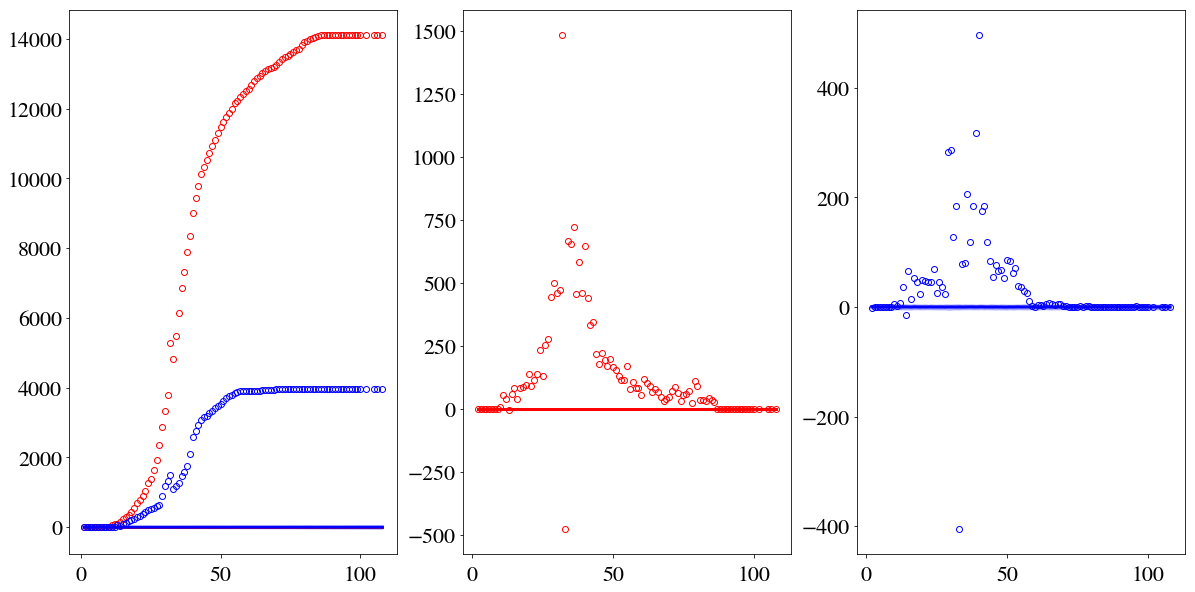

In [73]:
e.makeplot(samples=samples[selection], scatter=True)
#plt.gcf().axes[0].set_ylim(top=10000)
plt.savefig('plots/emcee_fit_intervals_scatter_{}.pdf'.format(country))

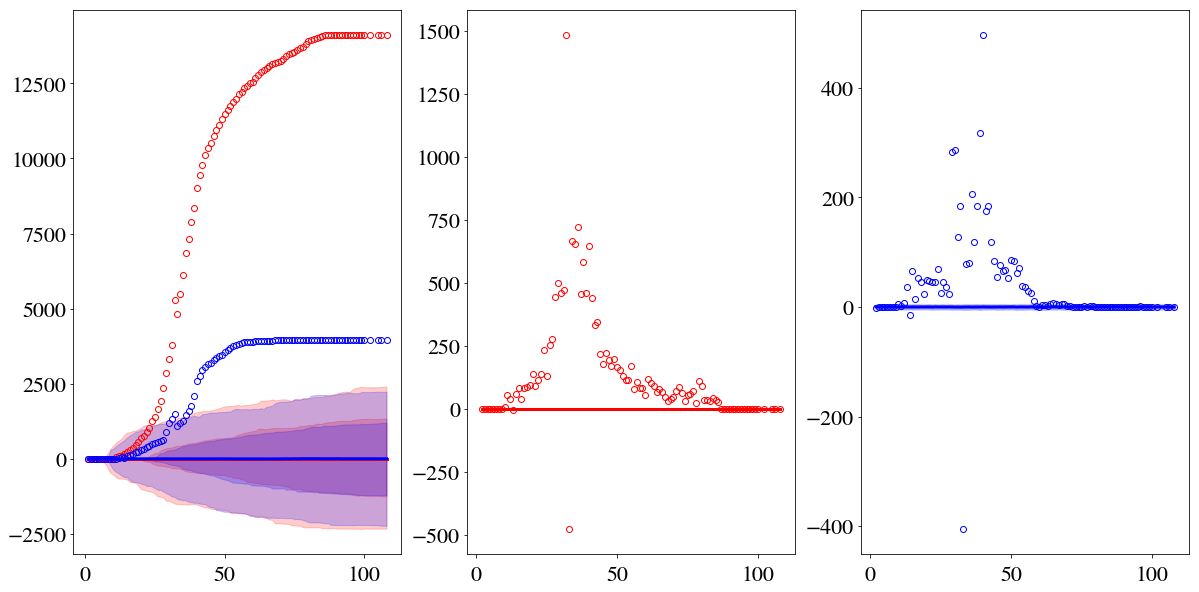

In [74]:
e.makeplot(samples=samples[selection], scatter=True, outliers=True)
#plt.gcf().axes[0].set_ylim(top=10000)
plt.savefig('plots/emcee_fit_intervals_scatter_outliers{}.pdf'.format(country))

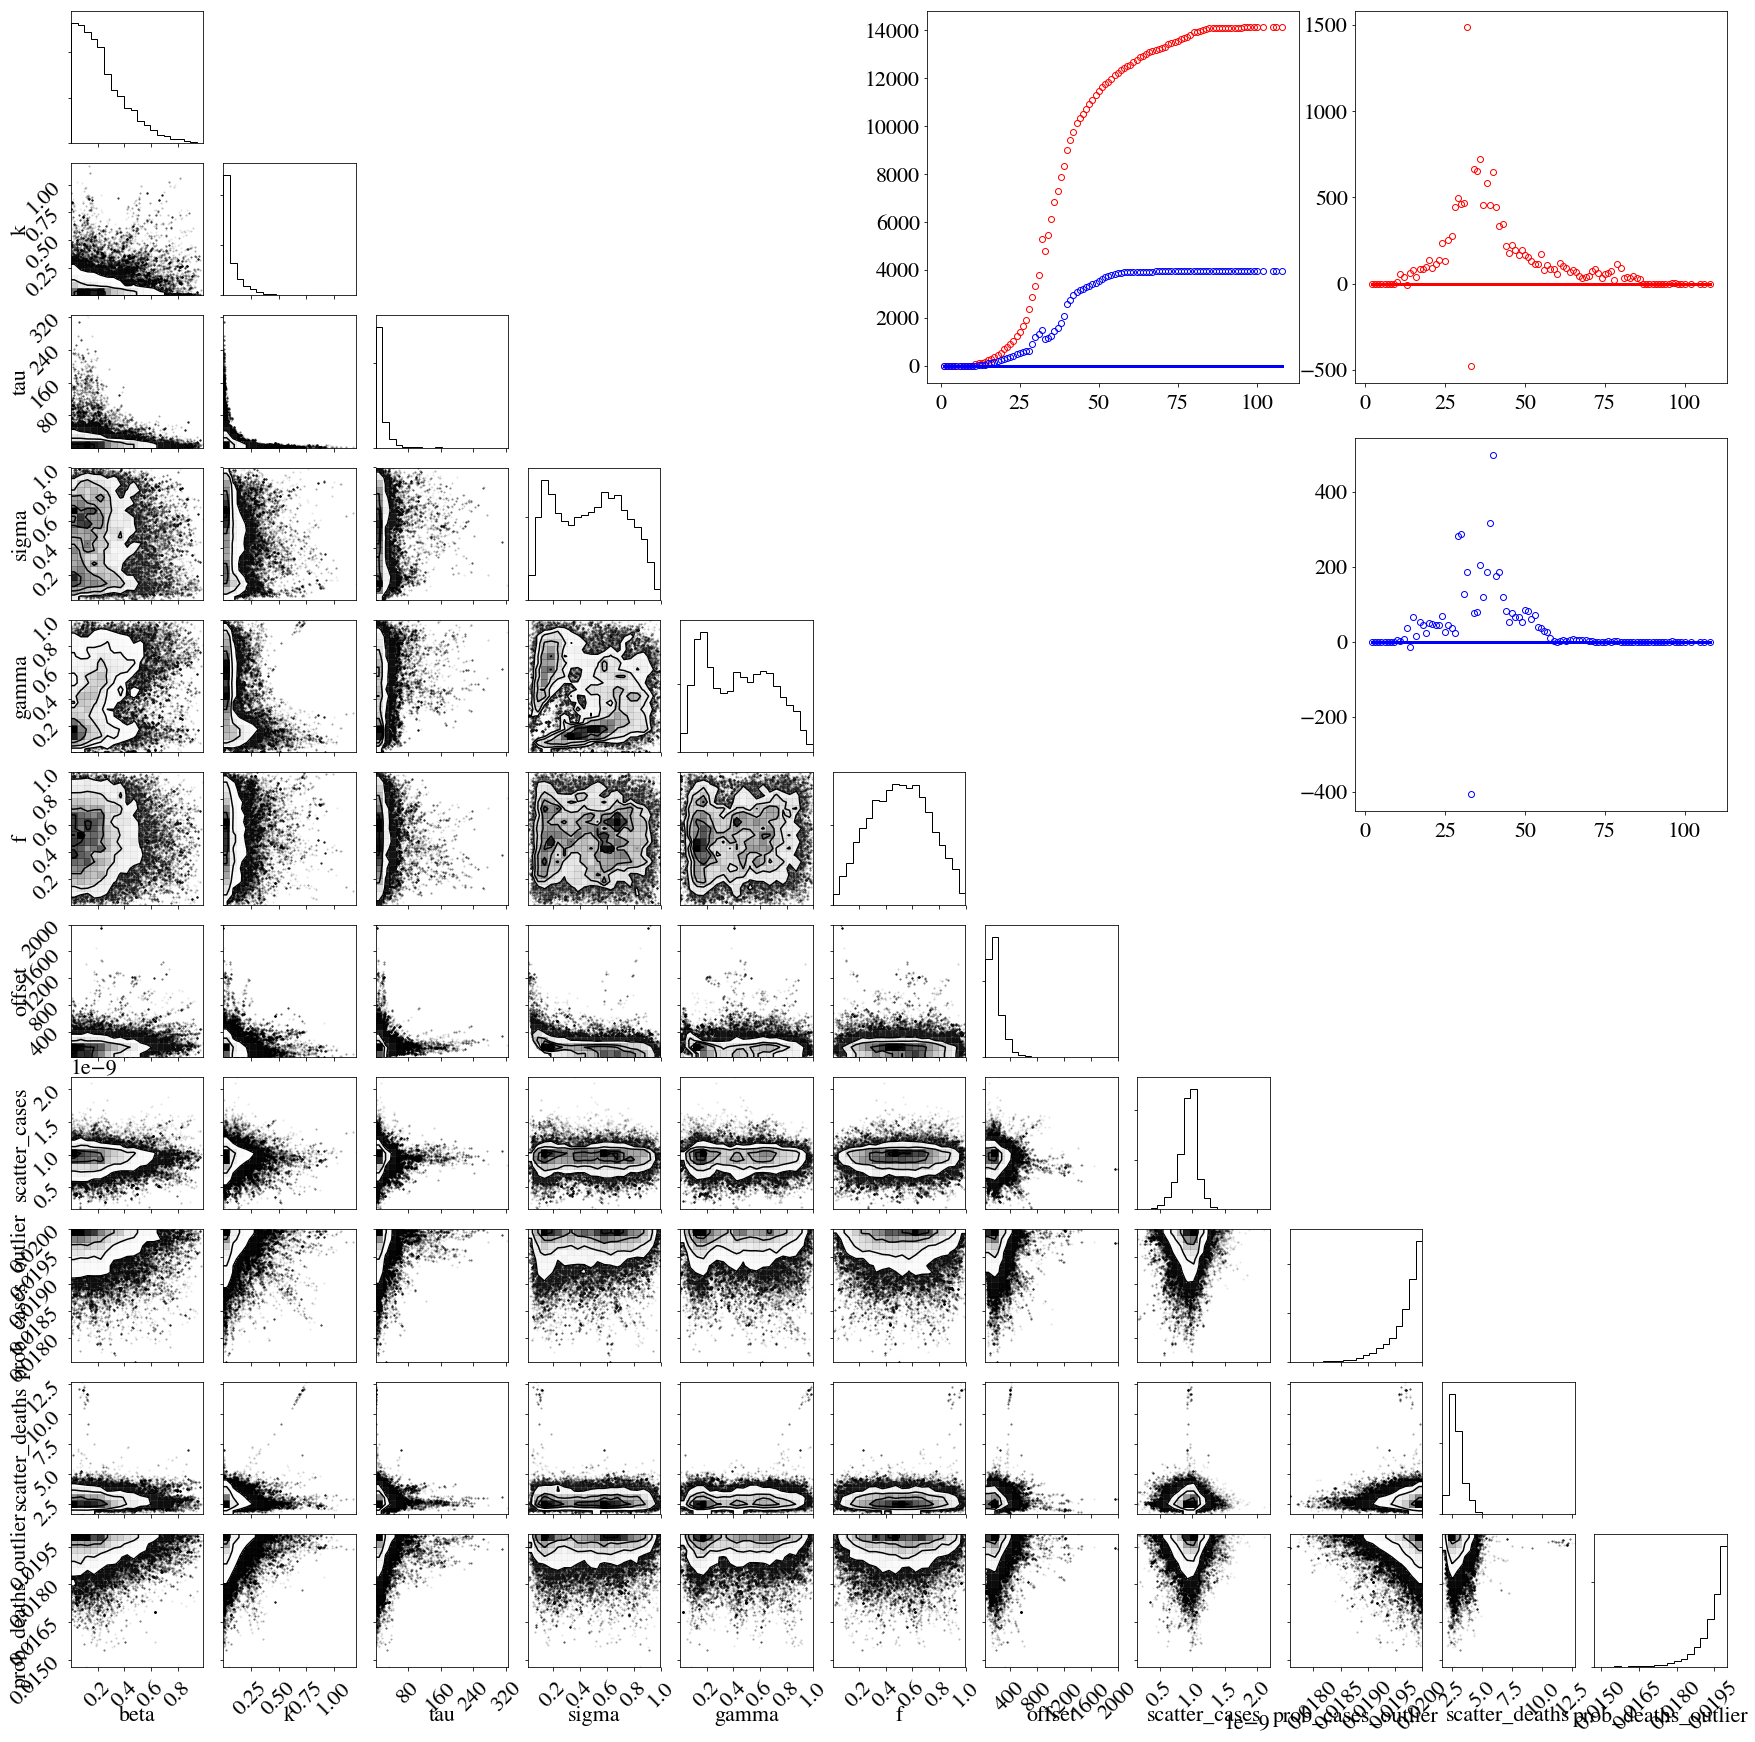

In [75]:
corner.corner(samples, labels=par)
ax0 = plt.subplot(4, 4, 3)
ax1 = plt.subplot(4, 4, 4)
ax2 = plt.subplot(4, 4, 8)
selection = np.random.choice(len(samples), 1000, replace=False)
e.makeplot(samples=samples[selection], ax=(ax0, ax1, ax2))
plt.subplots_adjust(wspace=0.15, hspace=0.15);
plt.savefig('plots/emcee_corner_{}.pdf'.format(country))